In [1]:
from gensim.models.word2vec import Word2Vec
import numpy as np

import urllib3
import pandas as pd
import os
import gc
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

C:\Users\gusals\anaconda3\envs\deep2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [3]:
train['full_log'][0]

'Sep 24 10:02:22 localhost kibana: {"type":"error","@timestamp":"2020-09-24T01:02:22Z","tags":["warning","stats-collection"],"pid":6458,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:226:15)\\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:214:7)\\n    at process._tickCallback (internal/process/next_tick.js:61:11)"},"message":"No Living connections"}'

In [4]:
print(train.shape, test.shape, submission.shape)

(472972, 3) (1418916, 2) (1418916, 2)


In [5]:
def process(data):
    tt = data
    tt=tt.apply(lambda x: re.sub(r'(\\n)',' ',x))
    tt=tt.apply(lambda x: re.sub(r'[-_=+,#/\?:;^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>\{\}`\'…》]',' ',x))
    tt=tt.apply(lambda x: re.sub(r'[0-9]+','',x))
    tt = tt.apply(lambda x: re.sub(r' [a-zA-Z] ',' ',x))

#     tt = tt.apply(lambda x: re.sub(r'[a-zA-Z]+\<',' <',x))
#     tt = tt.apply(lambda x: re.sub(r'\>[a-zA-Z]+','> ',x))
#     tt = tt.apply(lambda x: re.sub(r'[^a-z]',' ', x.lower()))
    tt=tt.apply(lambda x: re.sub(r'\s+',' ',x))
    
    return tt

In [6]:
tt= train.full_log.copy()

In [7]:
tt[0]

'Sep 24 10:02:22 localhost kibana: {"type":"error","@timestamp":"2020-09-24T01:02:22Z","tags":["warning","stats-collection"],"pid":6458,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:226:15)\\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:214:7)\\n    at process._tickCallback (internal/process/next_tick.js:61:11)"},"message":"No Living connections"}'

In [8]:
tt = process(tt)
tt[0]

'Sep localhost kibana type error timestamp tags warning stats collection pid level error error message No Living connections name Error stack Error No Living connections at sendReqWithConnection usr share kibana node modules elasticsearch src lib transport js at next usr share kibana node modules elasticsearch src lib connection pool js at process tickCallback internal process next tick js message No Living connections '

In [9]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gusals\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
print(word_tokenize(tt[153]))

['type', 'SYSCALL', 'msg', 'audit', 'arch', 'ce', 'syscall', 'success', 'yes', 'exit', 'c', 'b', 'items', 'ppid', 'pid', 'auid', 'uid', 'gid', 'euid', 'suid', 'fsuid', 'egid', 'sgid', 'fsgid', 'tty', 'none', 'ses', 'comm', 'ossec', 'syscheckd', 'exe', 'var', 'esild', 'bin', 'ossec', 'syscheckd', 'subj', 'unconfined', 'unconfined', 'unconfined', 's', 'c', 'key', 'audit', 'wazuh', 'type', 'CWD', 'msg', 'audit', 'cwd', 'type', 'PATH', 'msg', 'audit', 'item', 'name', 'etc', 'pki', 'ca', 'trust', 'extracted', 'pem', 'email', 'ca', 'bundle', 'pem', 'inode', 'dev', 'fd', 'mode', 'ouid', 'ogid', 'rdev', 'obj', 'system', 'object', 'cert', 's', 'objtype', 'NORMAL', 'type', 'PROCTITLE', 'msg', 'audit', 'proctitle', 'var', 'esild', 'bin', 'ossec', 'syscheckd']


In [11]:
tt[0]

'Sep localhost kibana type error timestamp tags warning stats collection pid level error error message No Living connections name Error stack Error No Living connections at sendReqWithConnection usr share kibana node modules elasticsearch src lib transport js at next usr share kibana node modules elasticsearch src lib connection pool js at process tickCallback internal process next tick js message No Living connections '

In [402]:
# from nltk.corpus import words
# nltk.download('words')
def text_preprocessing(text_list):
    
    stopwords = ['jan', 'feb', 'dec', 'sep', 'oct', 'nov', 'mar', 'level']
    
    token_list = []
    for text in tqdm(text_list):
        #txt = text.lower()
        #tagged = nltk.pos_tag(nltk.word_tokenize(text))
        #token = [word for word,pos in tagged if pos in ['NN', 'NNP']]
        #print(token)
        text = text.lower()
        text = re.sub(r'(\w*)ff(\w*)',' ',text)
        #text = re.sub(r'\w?!ff*\w',' ',text)
        text = re.sub(r'(\w*)bb(\w*)',' ',text)
        text = re.sub(r'(\w*)dd(\w*)',' ',text)
        text = re.sub(r'(\w*)ee(\w*)',' ',text)
        text = re.sub(r'[ㄱ-ㅣ가-힣]',' ',text)

#         text = re.sub(r'\wd*d',' ',text)
#         text = re.sub(r'\wc*c',' ',text)
#         text = re.sub(r'bb*',' ',text)
#         text = re.sub(r'cc*',' ',text)
#         text = re.sub(r'dd*',' ',text)
        token = text.split(' ')
        #token = [t for t in token if t in words.words()]
        token = [t for t in token if t not in stopwords and len(t) > 2 and len(t) < 20]
        token_list.append(token)
        #print(token)
    return token_list

train['token'] = text_preprocessing(tt)

100%|███████████████████████████████████████████████████████████████████| 472972/472972 [01:20<00:00, 5910.40it/s]


In [403]:
train['token'][0]

['localhost',
 'kibana',
 'type',
 'error',
 'timestamp',
 'tags',
 'warning',
 'stats',
 'collection',
 'pid',
 'error',
 'error',
 'message',
 'living',
 'connections',
 'name',
 'error',
 'stack',
 'error',
 'living',
 'connections',
 'usr',
 'share',
 'kibana',
 'node',
 'modules',
 'elasticsearch',
 'src',
 'lib',
 'transport',
 'next',
 'usr',
 'share',
 'kibana',
 'node',
 'modules',
 'elasticsearch',
 'src',
 'lib',
 'connection',
 'pool',
 'process',
 'tickcallback',
 'internal',
 'process',
 'next',
 'tick',
 'message',
 'living',
 'connections']

In [399]:
train_text=list(train['token'])
train_level=np.array(train['level'])

In [400]:
max_len = 100

In [401]:
def text2sequence(train_text, max_len=1000):
    
    tokenizer = text.Tokenizer(num_words = 3000, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    print('메일의 최대 길이 : %d' % max(len(l) for l in  train_X_seq ))
    X_train = pad_sequences(train_X_seq, maxlen = max_len)
    
    print(tokenizer.word_index)
    return X_train, vocab_size, tokenizer

train_y = train_level
train_X, vocab_size, vectorizer = text2sequence(train_text, max_len = max_len)
print(train_X.shape, train_y.shape)

vocab_size :  17162
메일의 최대 길이 : 932
{'<OOV>': 1, 'error': 2, 'type': 3, 'audit': 4, 'msg': 5, 'elasticsearch': 6, 'localhost': 7, 'kibana': 8, 'connections': 9, 'living': 10, 'cap': 11, 'usr': 12, 'message': 13, 'logstash': 14, 'pid': 15, 'system': 16, 'lib': 17, 'modules': 18, 'name': 19, 'node': 20, 'share': 21, 'syscall': 22, 'src': 23, 'proctitle': 24, 'cwd': 25, 'process': 26, 'next': 27, 'bin': 28, 'connection': 29, 'unconfined': 30, 'pool': 31, 'timestamp': 32, 'tags': 33, 'ossec': 34, 'syscheckd': 35, 'path': 36, 'object': 37, 'dev': 38, 'mode': 39, 'inode': 40, 'item': 41, 'ouid': 42, 'ogid': 43, 'rdev': 44, 'obj': 45, 'objtype': 46, 'normal': 47, 'outputs': 48, 'wazuh': 49, 'warning': 50, 'tty': 51, 'uid': 52, 'auid': 53, 'key': 54, 'arch': 55, 'exit': 56, 'transport': 57, 'comm': 58, 'euid': 59, 'exe': 60, 'ses': 61, 'suid': 62, 'subj': 63, 'gid': 64, 'success': 65, 'items': 66, 'ppid': 67, 'fsuid': 68, 'egid': 69, 'sgid': 70, 'fsgid': 71, 'yes': 72, 'none': 73, 'internal': 

In [367]:
train_X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,
        8,  3,  2, 33, 34, 51, 80, 82, 15,  2,  2, 13, 10,  9, 19,  2, 81,
        2, 10,  9, 12, 21,  8, 20, 18,  6, 23, 17, 58, 27, 12, 21,  8, 20,
       18,  6, 23, 17, 29, 32, 26, 76, 75, 26, 27, 77, 13, 10,  9])

In [368]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.05
RANDOM_SEED=42

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [369]:
X_train[153:154]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   7,   8,   3,  88,  33,  34,   2,  96, 101,
         15,  13,  86, 111,  90, 110,   2,  10,   9]])

In [370]:
train_df = pd.DataFrame(X_train)
train_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,14,2
1,0,0,0,0,0,0,0,0,0,0,...,32,26,76,75,26,27,77,13,10,9
2,0,0,0,0,0,0,0,0,0,0,...,32,26,76,75,26,27,77,13,10,9
3,0,0,0,0,0,0,0,0,0,0,...,11,11,11,11,85,3,24,5,4,24
4,0,0,0,0,0,0,0,0,0,0,...,3,24,5,4,24,12,235,332,372,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449318,0,0,0,0,0,0,0,0,0,0,...,89,2,6,92,84,7,103,107,29,100
449319,0,0,0,0,0,0,0,0,0,0,...,113,197,237,234,233,114,241,113,239,33
449320,0,0,0,0,0,0,0,0,0,0,...,46,16,38,47,48,3,24,5,4,24
449321,0,0,0,0,0,0,0,0,0,0,...,3,24,5,4,24,79,78,28,35,36


In [371]:
columns = train_df.columns

In [372]:
TAG_MIN = train_df[columns].min()
TAG_MAX = train_df[columns].max()

In [373]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [374]:
X_train = normalize(train_df[columns])
X_train

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002334,0.004668,0.000338
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010692,0.008757,0.025589,0.025075,0.008693,0.009027,0.025935,0.004335,0.003334,0.002707
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010692,0.008757,0.025589,0.025075,0.008693,0.009027,0.025935,0.004335,0.003334,0.002707
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003675,0.003705,0.003704,0.003678,0.028419,0.001003,0.008084,0.001667,0.001334,0.007783
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001002,0.008084,0.001684,0.001337,0.008024,0.004012,0.079151,0.110704,0.124041,0.094416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029736,0.000674,0.002020,0.030759,0.028084,0.002340,0.034692,0.035679,0.009670,0.033503
449319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.037755,0.066352,0.079798,0.078235,0.077900,0.038114,0.081172,0.037679,0.079693,0.010829
449320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015369,0.005389,0.012795,0.015714,0.016048,0.001003,0.008084,0.001667,0.001334,0.007783
449321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001002,0.008084,0.001684,0.001337,0.008024,0.026413,0.026271,0.009336,0.011671,0.011844


In [375]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.15
RANDOM_SEED=42

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [376]:
X_train.shape, X_val.shape

((381924, 100), (67399, 100))

In [377]:
def dnn(x):
    input_dim = x.shape[1]
    input = Input(shape=(input_dim, ))
    
    encode = Dense(x.shape[1], activation='relu')(input)
    #encode = Dense(128, activation='relu')(encode)
    encode = Dense(64, activation='relu')(encode)
    
    decode = Dense(64, activation='relu')(encode)
    #decode = Dense(128, activation='relu')(encode)
    decode = Dense(x.shape[1], activation='relu')(decode)

    autoencoder = Model(input, decode)

    autoencoder.summary()
    
    return autoencoder

In [378]:
model = dnn(X_train)
model.compile(optimizer='adam', loss='mse')
#model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
modelpath = "./model/0,1_{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)


epochs = 10
batch = 64


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 100)               6500      
Total params: 27,224
Trainable params: 27,224
Non-trainable params: 0
_________________________________________________________________


In [379]:
# fit
history = model.fit(X_train, X_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(X_val, X_val), callbacks=[early_stopping, checkpointer])

Epoch 1/10
5968/5968 [==============================] - 6s 1ms/step - loss: 2.3157e-04 - val_loss: 1.1541e-04

Epoch 00001: val_loss improved from inf to 0.00012, saving model to ./model\0,1_01-0.0001.hdf5
Epoch 2/10
5968/5968 [==============================] - 6s 963us/step - loss: 1.1275e-04 - val_loss: 9.1490e-05

Epoch 00002: val_loss improved from 0.00012 to 0.00009, saving model to ./model\0,1_02-0.0001.hdf5
Epoch 3/10
5968/5968 [==============================] - 6s 983us/step - loss: 1.0070e-04 - val_loss: 8.6154e-05

Epoch 00003: val_loss improved from 0.00009 to 0.00009, saving model to ./model\0,1_03-0.0001.hdf5
Epoch 4/10
5968/5968 [==============================] - 6s 941us/step - loss: 9.3107e-05 - val_loss: 8.2940e-05

Epoch 00004: val_loss improved from 0.00009 to 0.00008, saving model to ./model\0,1_04-0.0001.hdf5
Epoch 5/10
5968/5968 [==============================] - 6s 989us/step - loss: 8.8361e-05 - val_loss: 8.1359e-05

Epoch 00005: val_loss improved from 0.00008 t

KeyboardInterrupt: 

In [342]:
model = load_model('./model/0,1_10-0.0001.hdf5')

In [343]:
val_sample = pd.read_csv('./data/validation_sample.csv')
val_sample

,full_log
0,type=ANOM_PROMISCUOUS msg=audit(1600402733.466...
1,"oscap: msg: ""xccdf-result"", scan-id: ""00016007..."
2,Sep 22 10:56:19 localhost kernel: Out of memor...


In [344]:
val_tt = val_sample.full_log.copy()

In [345]:
val_tt = process(val_tt)
val_tt = text_preprocessing(val_tt)
val_tt[2]

100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


['localhost',
 'kernel',
 'out',
 'memory',
 'kill',
 'process',
 'probe',
 'rpmverify',
 'score',
 'sacrifice',
 'child']

In [346]:
val_smaple_data = vectorizer.texts_to_sequences(val_tt)
val_smaple_data = pad_sequences(val_smaple_data, maxlen=max_len)
val_smaple_data 

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    3,    1,    1,
           5,    4,   38,    1,    1,  448,    1,   53,   52,   65,   62,
           3,   22,    5,    4,   55,   22,   58,   72,   56,    1,   66,
          67,   15,   53,   52,   65,   60,   63,   68,   69,   70,   71,
          51,   73,   62,   59,    1,   61,   12,  215,  132,   64,   16,
          16,   30,   86,   54,  401,    3,   24,    5,    4,   24,  425,
        2755],
       [ 319,  260,  313,  320,  321,  260,  281,   83,  319,  260,  313,
         320,  321,  260,  281,   83,  410,  411,  412,  413,  515,  405,
         301,  414,  505,  506,   83,  410,  411,  412,  413,  512,  405,
         301,  414,  596,  391,  363,  312,  581,  385,  390,  281,  391,
         363,  636,  31

In [347]:
import pandas as pd
from numpy import vstack

# Combined x and x_test.
new_x = vstack([X_test, val_smaple_data])

In [348]:
new_x[-1:]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    7,  584,  569,  855, 2052,   26,  646,    1,    1,    1,
           1]])

In [349]:
new_df = pd.DataFrame(new_x)
new_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,7,8,...,197,125,85,168,144,293,202,85,125,199
1,0,0,0,0,0,0,0,0,0,0,...,131,140,139,117,123,136,137,135,138,96
2,0,0,0,0,0,0,0,0,0,0,...,31,26,75,74,26,27,76,13,10,9
3,0,0,0,0,0,0,0,0,0,0,...,31,26,75,74,26,27,76,13,10,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,14,112,161,158,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,14,141
23648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,14,141
23649,0,0,0,0,0,0,0,0,0,0,...,86,54,401,3,24,5,4,24,425,2755
23650,319,260,313,320,321,260,281,83,319,260,...,481,385,390,350,742,89,205,421,422,128


In [350]:
new_x = normalize(new_df[columns])
new_x

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.002354,0.002728,...,0.066174,0.042116,0.028381,0.056604,0.048550,0.098720,0.067672,0.028804,0.041989,0.067050
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.044004,0.047170,0.046411,0.039420,0.041470,0.045822,0.045896,0.045747,0.046355,0.032171
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.010413,0.008760,0.025042,0.024933,0.008766,0.009097,0.025461,0.004405,0.003359,0.002709
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.010413,0.008760,0.025042,0.024933,0.008766,0.009097,0.025461,0.004405,0.003359,0.002709
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002360,0.004717,0.037521,0.054558,0.053074,0.052828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002372,0.004703,0.047409
23648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002372,0.004703,0.047409
23649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.028888,0.018194,0.133890,0.001011,0.008092,0.001685,0.001340,0.008133,0.142761,0.932611
23650,0.121201,0.092395,0.104823,0.107491,0.107107,0.086753,0.09439,0.027694,0.107263,0.088646,...,0.161572,0.129717,0.130217,0.117925,0.250169,0.029987,0.068677,0.142664,0.141753,0.043007


In [351]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [352]:
y_val2 = np.zeros(len(y_test)+3)
y_val2[-1] = 1
y_val2[-2] = 2
y_val2[-3] = 3

# y_val2[:-3] = y_test
# y_val2

In [353]:
new_x.shape

(23652, 100)

In [354]:
predictions = model.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})


Text(0.5, 0, 'Data point index')

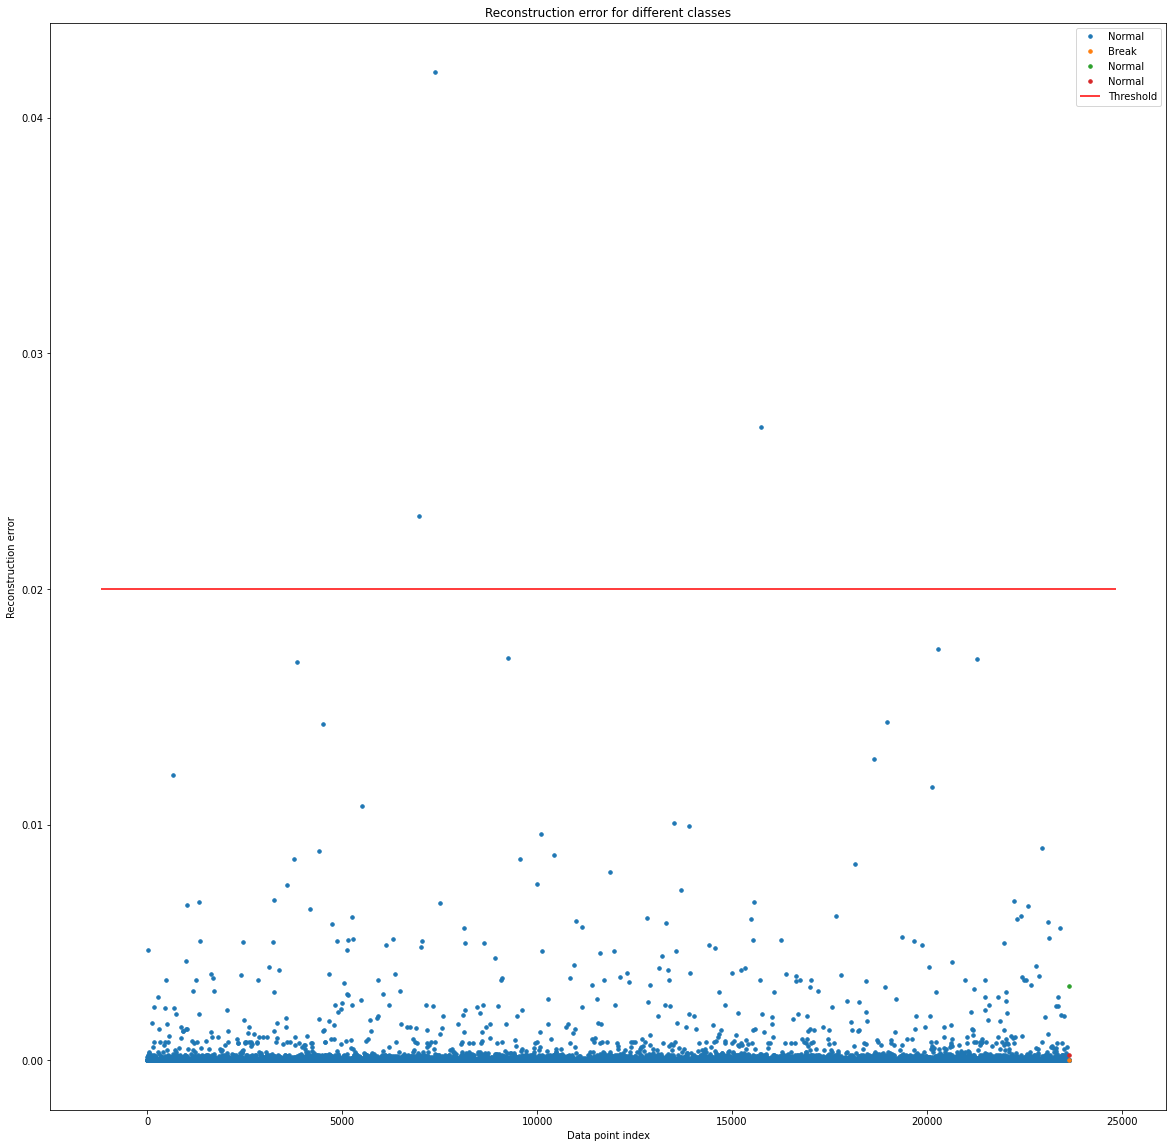

In [355]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(y_val2)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(0.02, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [71]:
test_tt = test.full_log.copy()

In [72]:
test_tt = process(test_tt)
test_tt = text_preprocessing(test_tt)
test_tt[1]

100%|████████████████████████████████████████████████████████████████| 1418916/1418916 [01:34<00:00, 15066.82it/s]


['localhost',
 'kibana',
 'type',
 'error',
 'timestamp',
 'tags',
 'warning',
 'stats',
 'collection',
 'pid',
 'error',
 'error',
 'message',
 'living',
 'connections',
 'name',
 'error',
 'stack',
 'error',
 'living',
 'connections',
 'usr',
 'share',
 'kibana',
 'node',
 'modules',
 'elasticsearch',
 'src',
 'lib',
 'transport',
 'next',
 'usr',
 'share',
 'kibana',
 'node',
 'modules',
 'elasticsearch',
 'src',
 'lib',
 'connection',
 'pool',
 'process',
 'tickcallback',
 'internal',
 'process',
 'next',
 'tick',
 'message',
 'living',
 'connections']

In [73]:
test_data = vectorizer.texts_to_sequences(test_tt)
test_data = pad_sequences(test_data, maxlen=max_len)
test_data 

array([[ 194,  234,   80, ...,  127,   66,   34],
       [   0,    0,    0, ...,    7,    6,    5],
       [   0,    0,    0, ...,  154, 1702,  704],
       ...,
       [   0,    0,    0, ...,  154, 1702,  704],
       [   0,    0,    0, ...,   50,   18,   52],
       [   0,    0,    0, ...,    7,    6,    5]])

In [74]:
test_data  = vstack([test_data, val_smaple_data])

In [75]:
test_df = pd.DataFrame(test_data)
test_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,194,234,80,155,169,156,9,42,155,223,...,17,28,7,93,102,128,60,127,66,34
1,0,0,0,0,0,0,0,0,0,0,...,19,16,27,26,16,17,28,7,6,5
2,0,0,0,0,0,0,0,0,0,0,...,429,659,1451,9,1185,241,200,154,1702,704
3,0,0,0,0,0,0,0,0,0,0,...,19,16,27,26,16,17,28,7,6,5
4,0,0,0,0,0,0,0,0,0,0,...,2307,699,247,429,153,1451,9,1185,241,1130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418914,0,0,0,0,0,0,0,0,0,0,...,36,1,2,37,33,4,47,50,18,52
1418915,0,0,0,0,0,0,0,0,0,0,...,19,16,27,26,16,17,28,7,6,5
1418916,0,0,0,0,0,0,0,0,0,0,...,247,233,913,237,9,1185,241,1328,1149,3241
1418917,41,757,57,1170,1906,476,1669,35,1705,39,...,722,749,536,744,492,43,136,867,868,409


In [76]:
test_df = normalize(test_df[columns])
test_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.056742,0.063570,0.033741,0.093037,0.057522,0.053079,0.005933,0.031674,0.075943,0.167166,...,0.004663,0.007678,0.001838,0.024480,0.026639,0.033605,0.015703,0.033229,0.017282,0.008737
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005211,0.004387,0.007090,0.006844,0.004179,0.004463,0.007328,0.001832,0.001571,0.001059
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.117663,0.180696,0.381040,0.002369,0.309480,0.063271,0.052342,0.040293,0.445666,0.186127
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005211,0.004387,0.007090,0.006844,0.004179,0.004463,0.007328,0.001832,0.001571,0.001059
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.632748,0.191664,0.064863,0.112924,0.039958,0.380940,0.002355,0.310047,0.063106,0.298914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009874,0.000274,0.000525,0.009739,0.008618,0.001050,0.012300,0.013082,0.004713,0.013503
1418915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005211,0.004387,0.007090,0.006844,0.004179,0.004463,0.007328,0.001832,0.001571,0.001059
1418916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.067745,0.063888,0.239758,0.062385,0.002350,0.311105,0.063072,0.347462,0.300864,0.857824
1418917,0.011992,0.205651,0.024040,0.702281,0.648741,0.161960,1.100198,0.026395,0.835375,0.029235,...,0.198025,0.205374,0.140756,0.195841,0.128493,0.011289,0.035593,0.226845,0.227285,0.108022


In [77]:
predictions = model.predict(test_df)

# Calculated MSE.
mse = np.mean(np.power(test_df  - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})


In [81]:
pred_y_test = [1 if e > 0.1 else 0 for e in (error_df['reconstruction_error'].values)]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(1418919,)

In [82]:

pred_y_test[-1] = 2
pred_y_test[-2] = 3
pred_y_test[-3] = 4

Text(0.5, 0, 'Data point index')

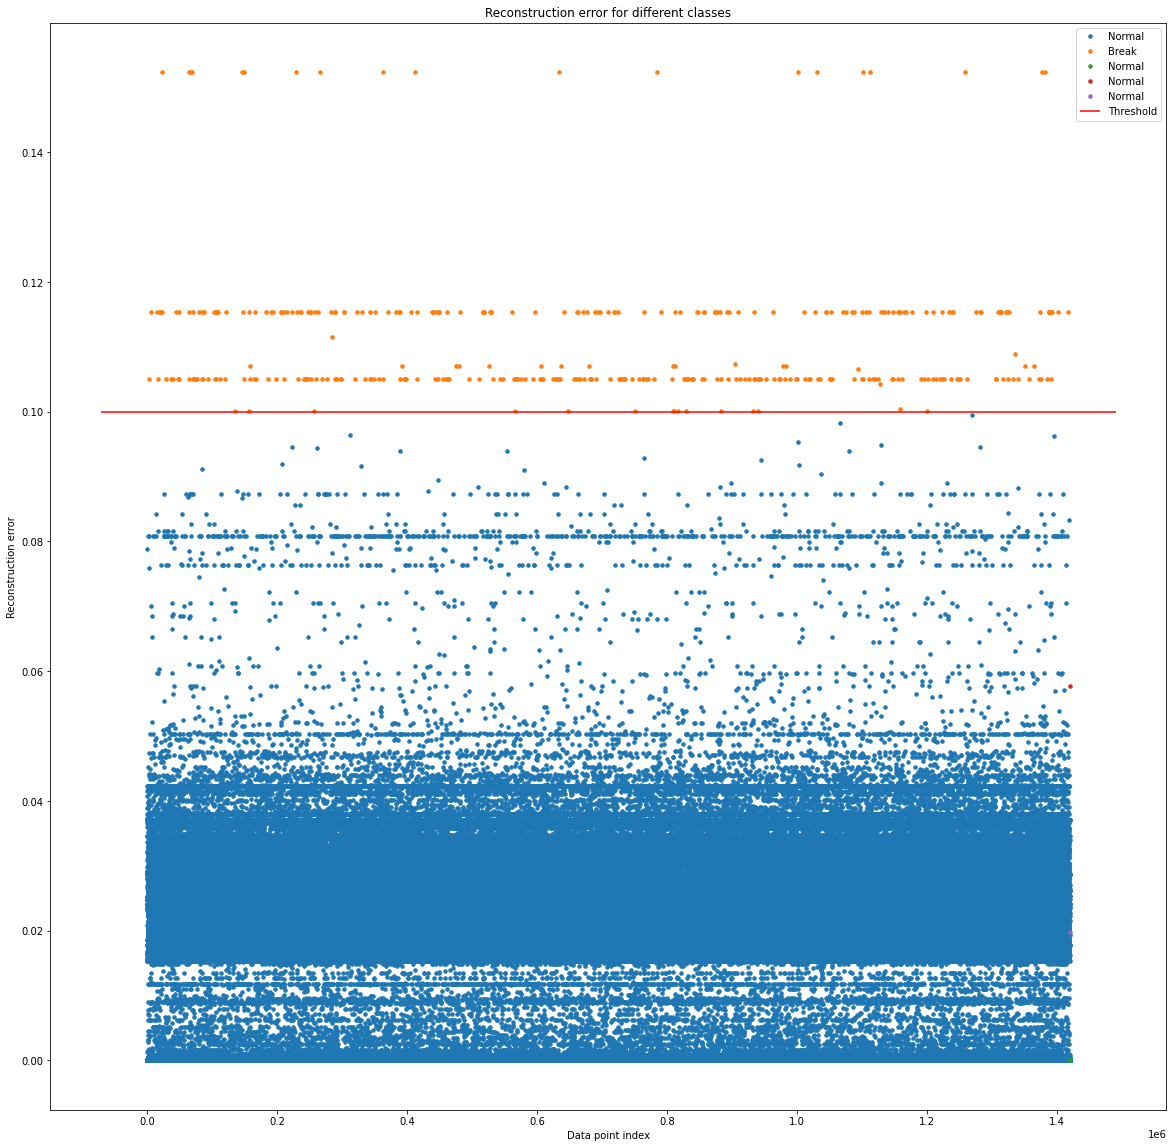

In [83]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(pred_y_test)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(0.1, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [84]:
test['predict'] = pred_y_test

ValueError: Length of values (1418919) does not match length of index (1418916)

In [179]:
submission['level']=pred_y_test

In [180]:
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,0
3,1000003,0
4,1000004,0
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,0
1418914,2418914,0


In [181]:
submission['level'].value_counts()

0    1418093
1        823
Name: level, dtype: int64